## Importing the Modules

In [2]:
import torch
from torch import nn # Containing the building block for creating Neural Networks (such us Convolutional and Linear layers)
import matplotlib.pyplot as plt

## Setting the device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cpu


## Defining the Problem

Lets say that we have a **Linear** Function `Y = aX + b` and given of the tuples
(X, Y) we are trying to estimate a and b.

In [4]:
# Defining the a, b that we will try to estimate
a, b = 0.3, 0.9

start, end, step = 1, 10, 0.1

# Creating the Linear Function
X = torch.arange(start, end, step).unsqueeze(dim=1) # We need the Tensors into row-vector shapes to be compatable with Pytorch `nn`
Y = a*X + b

print("X[:10]")
print(X[:10])

print("Y[:10]")
print(Y[:10])

X[:10]
tensor([[1.0000],
        [1.1000],
        [1.2000],
        [1.3000],
        [1.4000],
        [1.5000],
        [1.6000],
        [1.7000],
        [1.8000],
        [1.9000]])
Y[:10]
tensor([[1.2000],
        [1.2300],
        [1.2600],
        [1.2900],
        [1.3200],
        [1.3500],
        [1.3800],
        [1.4100],
        [1.4400],
        [1.4700]])


## Splitting the Data into Training and Test Samples

To understand why we need to split the data, we first need to understand the process that a Neural Network follows to learn:
- First using the `training set`, train itself, meaning it adjust the **weights** and **biases** so the feutures of the training set to match with the targets.
- Then based on that training evaluate the model using the `validation set`. If we try to evaluate the model using the training set then the results will be wrong, because the model have already create the patterns for the seen data, but we want it to also work with unseen data, thus the validation set (this attribute is called **Generalization**).
- Finally we test the model using the `testing set`, that contains data that the model has never seen.

So by splitting the data, we aquire higher accuracy and precession metrics.

On problems with small dataset (such us that) we often skip the `validation set`.

The percentages of those sets in size is as follows:
- Training   : 60-80 %
- Validation : 10-20 %
- Test       : 10-20 %

In [5]:
print(len(X), len(Y))

90 90


In [6]:
# So we are going to create a training (80%) and a test set (20%)
split = int(0.8 * len(X))

train_x, train_y = X[:split], Y[:split]
test_x, test_y = X[split:], Y[split:]

# There are more ways of splitting the data (that also inludes `randomness`), but we will see them later on.

## Move the Data to Device

In [7]:
train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

## Visualizing the Data

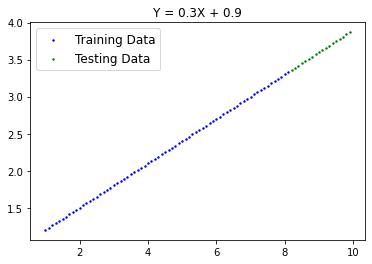

In [8]:
def visualize(pred=None):
    # We need `.cpu()` because matplotlib is working with numpy arrays, that cannot be stored in GPU
    plt.scatter(train_x.cpu(), train_y.cpu(), c='b', s=2, label="Training Data")
    plt.scatter(test_x.cpu(), test_y.cpu(), c='g', s=2, label="Testing Data")
    
    if pred is not None:
        plt.scatter(test_x.cpu(), pred.cpu(), c='r', s=2, label="Predictions")

    plt.title(f"Y = {a}X + {b}")
    plt.legend(fontsize="large")
    plt.show()

visualize()

## Building the Model

In [9]:
# Every Model that we are going to create have to be a class that inherits for `nn.Module` so we can use by default
#   some methods that Pytorch have created for working with Models (one example is 'to()' method)

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # We need to define weight and bias as `nn.Parameters` so we can access them as an iterator later on
        self.weight = nn.Parameter(torch.randn(size=(1,), requires_grad=True, dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(size=(1,), requires_grad=True, dtype=torch.float32))

        """
        Instead of manualy defining the weights and biases we can only specify the layers of the Neural Network:
        (Behind the scenes it is creating those parameters for us)

        * self.linear_layer = nn.Linear(in_features=1, out_features=1)
        """

    # Now we need to define the __call__() (also called forward()) method, that will help us in the training loop
    # In sort, it calculates the label of the given feature x
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return (x * self.weight) + self.bias

        """
        The same code, if we define the linear layer can be written:

        * return self.linear_layer(x)
        """

## How does the Model adjust the random parameters?

The answer is through 2 main algorithms
- Gradient Descent
- Backpropagation

## Creating out Model

In [10]:
model = LinearRegressionModel()

# Why not setting a random seed
torch.manual_seed(9)

# Getting the model's parameters (returns a generator object)
print(list(model.parameters()))

# We can see also the names and the values of the model's parameters
print(model.state_dict())

[Parameter containing:
tensor([-0.6512], requires_grad=True), Parameter containing:
tensor([-0.6687], requires_grad=True)]
OrderedDict([('weight', tensor([-0.6512])), ('bias', tensor([-0.6687]))])


## Move the Model to Device

In [11]:
# We can see the device that the Model is stored using:
print(next(model.parameters()).device) # We need `next()` because `model.parameters()` is a generator object (so we need the first element)

model.to(device) # Moving the model to device

print(next(model.parameters()).device)

cpu
cpu


## Make Prediction with the Model

tensor([[-6.0088],
        [-6.0739],
        [-6.1390],
        [-6.2042],
        [-6.2693],
        [-6.3344],
        [-6.3995],
        [-6.4647],
        [-6.5298],
        [-6.5949],
        [-6.6600],
        [-6.7251],
        [-6.7903],
        [-6.8554],
        [-6.9205],
        [-6.9856],
        [-7.0508],
        [-7.1159]])


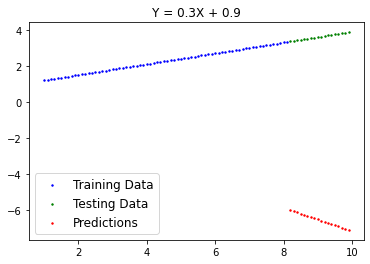

In [12]:
# We use this contex manager (better version of torch.no_grad()) when we are certain out operations will have no interact with autograd
# Gives us better performance (turns off gredient tracking)
with torch.inference_mode():
    preds = model(test_x)

print(preds)

# Ploting the predictions
visualize(preds)

## Training the Model

* Our goal is the adjust the **weight** and **bias** so the predictions from the model to match with the actual targets.
* So we are trying to go from a poor representation of the data to a better one.
* The measure of how poor the representation of the data is, give us a `loss function`.
* We can see all the loss functions that Pytorch has created in `torch.nn`.
* Then after we calculate the loss of the model, we need an `optimizer`, meaning to adjust the models parameters to imporve the loss function.

## Creating a Loss Function

In [13]:
# There are a lot of Loss functions available.
# We are going to create the L1 loss functions (Manhattan Norm)
def L1_norm(preds, targets):
    return torch.mean(torch.abs(preds - targets))

# The same can be accessed in: 'torch.nn.L1Loss()'

loss_fn = nn.L1Loss() # Not great results
loss_fn = nn.MSELoss()

## Creating an Optimizer

In [14]:
# The different optimizers we can use live in: 'torch.optim' class
# In that example we are going to use stohastic gradient descent

# The optimizer need some parameters:
# 1) the model parameters
# 2) the learning rate (the higher the learning rate the more optimizer adjust the parameters each epoch)

# A great concept about the learning rate is `learning rate scheduling`

lr = 1e-2

optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

## Creating the Training Loop
The process that the model follows to learn:
0. Loop through the data a lot of times (epochs)
1. Generate predictions (Forward Pass)
2. Calculate the Loss
3. Optimizer zero grad
4. Loss backward to calculate the gradients of the parameters (**backpropagation**)
5. Optimizer step to adjust the model parameters (**gradient descent**)

In [15]:
# An epoch is one loop through the data
epochs = 1001

# Tracking the progression of the model
epoch_count = []
loss_values = []


# 0. Loop through the data
for epoch in range(1, epochs):
    
    # Setting the model to training mode (starts gredient tracking)
    model.train()

    # 1. Forward Pass
    preds = model(train_x)

    # 2. Calculate Loss
    loss = loss_fn(preds, train_y) # preds first and then targets

    # 3. Optimizer zero grad (making all the gradients zero, to calculate them again for this loop)
    optimizer.zero_grad()

    # 4. Perform Backpropagation
    loss.backward()

    # 5. Optimize
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")
        epoch_count.append(epoch)
        loss_values.append(loss.item())

Epoch: 100 | Loss: 0.16203954815864563
Epoch: 200 | Loss: 0.08297154307365417
Epoch: 300 | Loss: 0.04248517379164696
Epoch: 400 | Loss: 0.0217543076723814
Epoch: 500 | Loss: 0.011139179579913616
Epoch: 600 | Loss: 0.0057037645019590855
Epoch: 700 | Loss: 0.002920585684478283
Epoch: 800 | Loss: 0.0014954726211726665
Epoch: 900 | Loss: 0.0007657523383386433
Epoch: 1000 | Loss: 0.0003921074094250798


In [16]:
print(model.state_dict())

OrderedDict([('weight', tensor([0.3087])), ('bias', tensor([0.8525]))])


## Testing the Model

Test Loss: 0.0009933196706697345


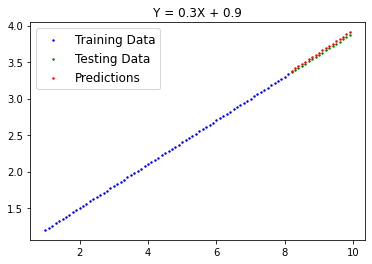

In [17]:
# Setting the model to evaluating mode
model.eval()

with torch.inference_mode():
    # 1. Forward Pass
    preds = model(test_x)

    # 2. Calculate Loss
    loss = loss_fn(preds, test_y)

print(f"Test Loss: {loss}")

visualize(preds)

## Plotting the Loss Curve

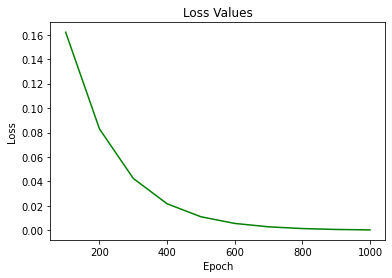

In [18]:
plt.plot(epoch_count, loss_values, c='g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Values")
plt.show()

## Saving the Model

The recommended way of saving a model is saving its `state dictionary` and not the entire model

In [19]:
# To save a model first we need to create its Path
from pathlib import Path

# 1. Create the Models Directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create the Model Save  path
MODEL_NAME = "function_approximation.pth" # Pytorch model should contain the extension `.pth`
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the state dict
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

## Loading a Model

Can load models that have been saved using `torch.save()`

In [20]:
# 1. Creating a new Model Instance
model1 = LinearRegressionModel()

# 2. Move the new model to device
model1.to(device)

# 2. Load the state dict into that model
model1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

print(model1.state_dict())
print(model1.state_dict() == model.state_dict())

OrderedDict([('weight', tensor([0.3087])), ('bias', tensor([0.8525]))])
True


## Pytorch Chear Sheet

https://pytorch.org/tutorials/beginner/ptcheat.html